# Plotting CUES and GOES data

Make an example plot of ground-based CUES observations of downward longwave radiation, snow-surface temperature, and sun/no-sun flag against GOES ~11 micron band brightness temperature observations.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt

%matplotlib inline

In [2]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

---
## Open data files

Open the CUES temperature data files, and concatenate them together

In [3]:
directory = r'\\j-lundquist-3.ce.washington.edu\storage\CUES\Level 1 - Database\temperature'
cues_temp_files = getListOfFiles(directory)

In [4]:
cues_temp_data = []
_ = [cues_temp_data.append(pd.read_csv(i)) for i in cues_temp_files]
cues_temp_data = pd.concat(cues_temp_data)

# Convert the 'DateTime' text strings to pandas datetime objects
cues_temp_data['datetime']  = pd.to_datetime(cues_temp_data['MeasDateTime'])

Load GOES observations for the CUES site

In [5]:
directory = r'\\j-lundquist-3.ce.washington.edu\storage\GOES\pkl\CUES'
goes_files = getListOfFiles(directory)

In [6]:
goes = []
_ = [goes.append(pd.read_pickle(i)) for i in goes_files]
goes = pd.concat(goes)

# Change GOES time values from UTC to UTC-7 for CUES site:
goes = goes.rename(columns={'time': 'timeUTC'})
goes['datetime'] = goes['timeUTC'] - pd.Timedelta(hours=7)

Load MODIS observations of the CUES site

In [7]:
#modis_1 = pd.read_pickle('./MODIS_data/cues_2017_1-59.pkl')
#modis_2 = pd.read_pickle('./MODIS_data/cues_2017_60-120.pkl')
#
## Concatenate the two MODIS time series together
#modis = pd.concat([modis_1, modis_2], ignore_index=True)

Convert pandas dataframes to xarray datasets

In [8]:
# Convert pandas dataframes to xarray datasets
# and make our local time datetimes the index

_goes = goes.set_index('datetime')
_goes.sort_index(inplace=True)
_goes = _goes.loc[~_goes.index.duplicated(keep='first')] # there are duplicates somewhere in the GOES data, remove them
_goes = _goes.loc[_goes.index >= pd.datetime(2017,2,28)]# there's also some values before 2017, remove them
goes_ds = _goes.to_xarray()

_cues_temp_data = cues_temp_data.set_index('datetime')
_cues_temp_data.sort_index(inplace=True)
cues_ds = _cues_temp_data.to_xarray()

---
## Make example plot

Set font sizes for plots

In [9]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


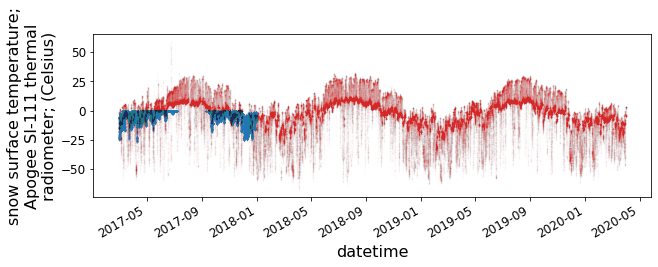

In [10]:
# quick preview plot to see what time period of GOES data we have
f, ax = plt.subplots(figsize=(10,3))
goes_ds.tb.plot(c='tab:red', linestyle='-', marker='.', markersize='2', ax=ax, alpha=0.01)
cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].plot(c='tab:blue', linestyle='-', marker='.', markersize='2', ax=ax, alpha=0.01)

Plot CUES snow surface temperature, CUES downward longwave, GOES 11 micron band brightness temperature

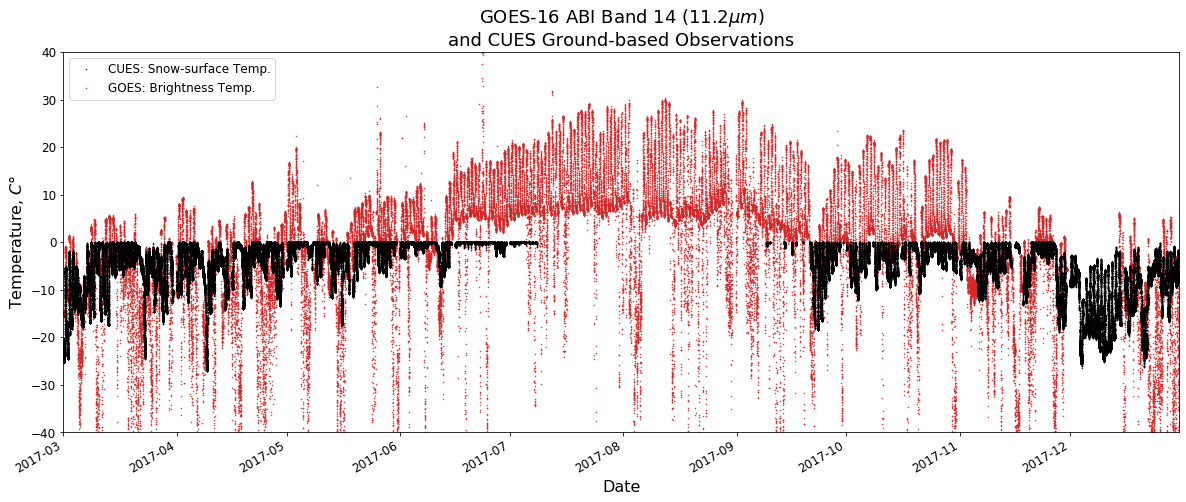

In [11]:
# Set start and end dates for time period we want to look at
startdate = cues_ds.datetime.min().values
enddate = cues_ds.datetime.max().values

# Set up figure
fig, ax = plt.subplots(figsize=(20,7))

# Plot CUES snow surface temperature
cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].plot(
    c='k', marker='.', ax=ax, markersize=1, linestyle='none', zorder=99)

# Plot GOES brightness temperature
goes_ds.tb.plot(c='tab:red', linestyle='none', marker='.', markersize=1, ax=ax)

# Plot MODIS
#modis_temp = modis.plot(x='datetime',y='temp_mean', marker='s',c='r',linestyle='None',ax=ax)
# MODIS error bars
#ax.errorbar(modis.datetime,modis.temp_mean,
#             yerr=[np.abs(modis.temp_min-modis.temp_mean),abs(modis.temp_max-modis.temp_mean)],
#             linestyle='None',c='r',linewidth=2,capsize=4,alpha=0.5)


# Format axes
#from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
#                               AutoMinorLocator)
#myFmt = mdates.DateFormatter('%D')
#ax.xaxis.set_minor_locator(MultipleLocator(1/24))
#ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_major_formatter(myFmt)
#ax.tick_params(axis='x', labelrotation=0) 
ax.set_xlim([startdate,enddate])
ax.set_ylim([-40,40])
ax.set_ylabel('Temperature, $C\degree$')
ax.set_xlabel('Date')

# Make legend
lines = [ax.lines[0], ax.lines[1]]
labels = ['CUES: Snow-surface Temp.', 'GOES: Brightness Temp.']
ax.legend(lines, labels, loc='upper left')

# Set title
plt.title('GOES-16 ABI Band 14 ($11.2 \mu m$)\nand CUES Ground-based Observations');

# Save figure image
#plt.savefig('goes-vs-cues-2017.jpg',dip=300);

Find matching CUES and GOES observations.

CUES snow-surface temperature is a 1-minute observations, GOES is 5-minute, so first aggregate CUES into 5-minute means:

In [12]:
# Resample the 1-minute CUES to 5-minute mean CUES Tss
cues_ds_5min = cues_ds.resample(datetime='5T').mean()

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\xarray\core\nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


We only want to look at when we have snow on the surface (according to the CUES data), so first drop data where Tss=nan:

In [13]:
cues_ds_5min = cues_ds_5min.where(~cues_ds_5min['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].isnull(), drop=True)

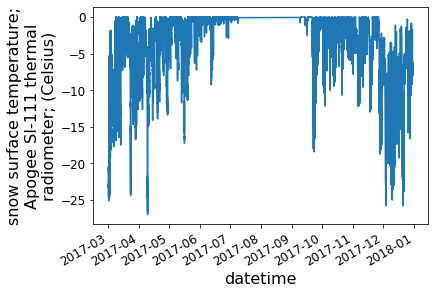

In [14]:
cues_ds_5min['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].plot()

In [49]:
goes_ds

<xarray.Dataset>
Dimensions:   (datetime: 316311)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2017-02-28T00:02:49.685997952 ... 2020-03-31T16:56:17.871328896
Data variables:
    timeUTC   (datetime) datetime64[ns] 2017-02-28T07:02:49.685997952 ... 2020-03-31T23:56:17.871328896
    tb        (datetime) float32 -13.587921 -13.459991 ... 1.3554382 1.3554382

Then for each CUES observation of snow-surface temperature, find the nearest GOES observation:

In [54]:
# Find nearest GOES Tb observation given a CUES datetime
_goes_ds = goes_ds.sel(datetime=cues_ds_5min.datetime.values, method='nearest')

In [55]:
cues_ds_5min['goes_tb'] = _goes_ds.tb.values

Text(0.5, 1.0, 'GOES-16 ABI Band 14 ($11.2 \\mu m$)\nand CUES Ground-based Observations')

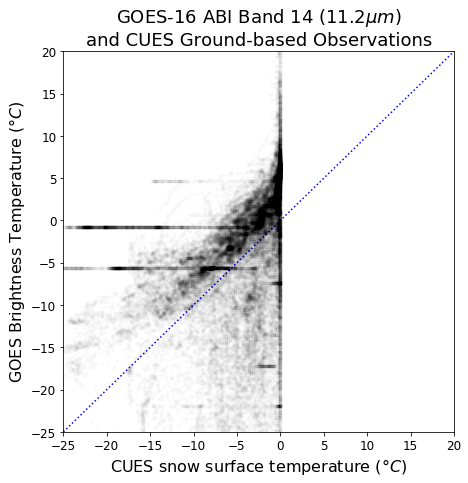

In [67]:
plt.figure(figsize=(7,7))
plt.plot(cues_ds_5min['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'],
         cues_ds_5min['goes_tb'],'.k',alpha=0.01,zorder=99)
plt.ylabel('GOES Brightness Temperature ($\degree C$)')
plt.xlabel('CUES snow surface temperature ($\degree C$)')
plt.xlim([-25,20])
plt.ylim([-25,20])
plt.plot([-25,20],[-25,20],'b:')
#plt.plot([-25,20],[0,0],':',c='lightgrey')
#plt.plot([0,0],[-25,20],':',c='lightgrey')
plt.title('GOES-16 ABI Band 14 ($11.2 \mu m$)\nand CUES Ground-based Observations')

Add this to our dataset, and save this dataset for future use.

In [21]:
cues_ds_5min['goes_tb_c'] = tb

startdate = cues_ds_5min.datetime.min().values
enddate = cues_ds_5min.datetime.max().values

# Export this the dataframe to a pickle file
goes_vs_insitu.to_netcdf("goes16-vs-cues_{}-{}.pkl".format(str(startdate),str(enddate)), protocol=3)

ValueError: cannot reindex or align along dimension 'datetime' because the index has duplicate values

------

Text(0.5, 0, 'Hour of Day')

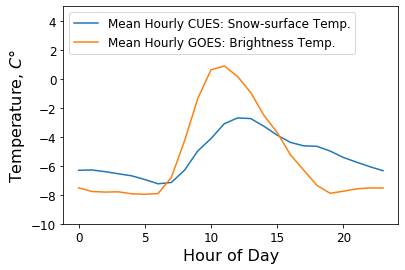

In [26]:
fig, ax = plt.subplots()
cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].groupby('datetime.hour').mean().plot(ax=ax)
goes_ds.tb.groupby('datetime.hour').mean().plot(ax=ax)

# Make legend
lines = [ax.lines[0], ax.lines[1]]
labels = ['Mean Hourly CUES: Snow-surface Temp.', 'Mean Hourly GOES: Brightness Temp.']
ax.legend(lines, labels, loc='upper left')

ax.set_ylim([-10,5])
ax.set_ylabel('Temperature, $C\degree$')
ax.set_xlabel('Hour of Day')

In [27]:
# Get all the GOES datetimes that are within the minimum and maximum CUES datetimes
# (because right now, we have a longer GOES record than CUES record,
# and want to only match observations 1-to-1)
times = goes_ds.datetime[(goes_ds.datetime >= cues_ds.datetime.min()) & (goes_ds.datetime <= cues_ds.datetime.max())]
# Get the GOES brightness temperatures that match these times too
tb = goes_ds.tb[(goes_ds.datetime >= cues_ds.datetime.min()) & (goes_ds.datetime <= cues_ds.datetime.max())]

In [28]:
# Find nearest CUES datetime given a GOES datetime
c = cues_ds.sel(datetime=tb.datetime, method='nearest', tolerance='5T')

c['goes_tb'] = tb.values


KeyError: "not all values found in index 'datetime'"

In [29]:
plt.figure(figsize=(7,7))
plt.plot(c['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'],c.goes_tb,'.k',alpha=0.01)
plt.ylabel('GOES Brightness Temperature ($\degree C$)')
plt.xlabel('CUES snow surface temperature ($\degree C$)')
plt.xlim([-25,20])
plt.ylim([-25,20])
plt.plot([-25,20],[-25,20],'b:')
plt.plot([-25,20],[0,0],':',c='lightgrey')
plt.plot([0,0],[-25,20],':',c='tab:grey')
plt.title('GOES-16 ABI Band 14 ($11.2 \mu m$)\nand CUES Ground-based Observations')

KeyError: 'snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'

<Figure size 504x504 with 0 Axes>

In [ ]:
plt.figure(figsize=(7,7))
plt.plot(c['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'],tb,'.k',alpha=0.01)
plt.ylabel('GOES Brightness Temperature ($\degree C$)')
plt.xlabel('CUES snow surface temperature ($\degree C$)')
plt.xlim([-25,20])
plt.ylim([-25,20])
plt.plot([-25,20],[-25,20],'b:')
plt.plot([-25,20],[0,0],':',c='lightgrey')
plt.plot([0,0],[-25,20],':',c='tab:grey')
plt.title('GOES-16 ABI Band 14 ($11.2 \mu m$)\nand CUES Ground-based Observations')

In [ ]:
# Compute the difference in temperatures (GOES - CUES)
delta_t = []
cues_tss = []
goes_tb = []

_goes_time = goes_ds.datetime

#times = (_goes_time > np.min(_cues_time)) & (_goes_time < np.max(_cues_time))

In [ ]:
plt.plot(c.datetime,times)


In [ ]:
for t in _goes_time[times]:
    print(t)
    goes_time = (nearest(_goes_time,t))
    tb = _goes_tb[_goes_time == goes_time]
    goes_tb.append(tb)
    
    tss = _cues_tss[_cues_time==t]
    cues_tss.append(tss)

    
    delta_t.append(tb - tss)


In [ ]:
# make a dict with all the data
d = {'datetime': _goes_time[times], 
     'goes_tb': goes_tb, 
     'cues_tss': cues_tss,
     'delta_t': delta_t
     }
# make the dict a pandas dataframe
goes_vs_insitu = pd.DataFrame(data=d)


goes_vs_insitu

# Export this the dataframe to a pickle file
goes_vs_insitu.to_pickle("goes16-vs-cues_02-2017-08-2017.pkl", protocol=3)